# Modeling

We have cleaned and processed the data from the below sources in our Cleaning and Preprocessing Notebooks. 

1. Airline Tweet Sentiments dataset | https://data.world/crowdflower/airline-twitter-sentiment

2. Apple Tweet Sentiment dataset | https://data.world/crowdflower/apple-twitter-sentiment

3. Sentiment 140 dataset | https://www.kaggle.com/datasets/kazanova/sentiment140/

4. Tweet 4 Sentiment Analysis dataset | http://www.t4sa.it


This notebook contains the modeling process for our tweet sentiment classifier, outlined as follows:

- Train (80%) / Test (10%) / Validation (10%) Split
- Function to vectorize text and train, evaluate model
- Model iterations

## Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectFromModel

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss, confusion_matrix
from sklearn.pipeline import Pipeline

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For Latent Semantic Analysis (LSA)
from sklearn.decomposition import TruncatedSVD

# Classifier Algorithms
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

# for vizzies
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data

In [3]:
# Load up data
df = pd.read_csv('../data/processed_data.csv', index_col='Unnamed: 0', dtype={'sentiment': int})

df.head()

,sentiment,text
0,1,said
1,2,plus added commercials experience tacky
2,1,today must mean need take another trip
3,0,really aggressive blast obnoxious entertainmen...
4,0,really big bad thing


In [4]:
df.isna().value_counts()

sentiment  text 
False      False    2294857
           True           1
dtype: int64

We don't understand why we are creating a null value by saving down and reading in from the previous notebook. We have investigated and tried to solve, but for now let's just drop this guy.

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(2294857, 2)

Great. Now the data is ready to be split up. Let's also set a universal random state here to use in the rest of the notebook. 42!

In [7]:
random_state = 42

## Three-Way Data Splitting

In [8]:
# Split into "train/test" data and "validation" data
X = df.text
y = df.sentiment
X_tt, X_val, y_tt, y_val = train_test_split(X, y, random_state=random_state, test_size=0.1)

Okay, so we've created our X_val and y_val, which we won't touch again until we have found a model we are happy with.

Now we will do one more split to create our training and testing data to use in the iterative process. Remember, we want our testing set to be the same size as our validation set, equal to 10% of our total data. To do this, we need to set the test_size equal to `10%/90%` (or 1/9) because we are splitting up our remaining 90% of data. 

In [9]:
# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_tt, y_tt, random_state=random_state, test_size=(1/9))

## Model Evaluation Function

We want to build a function that we can use for each model to quickly get an idea of its performance. We also like using OOP because we can later reference each model eval instance to compare the models on performance.

In [10]:
class ModelEval():
    
    def __init__(self, estimator, vectorizer, name, X_train=X_train, X_test=X_test,\
                 y_train=y_train, y_test=y_test, lsa=False, lsa_components=100,\
                 random_state=random_state):
        
        self.estimator = estimator
        self.vectorizer = vectorizer
        self.name = name
        
        # Vectorize the data and define X with or without LSA
        if lsa == True:
            svd = TruncatedSVD(n_components=lsa_components, random_state=random_state)
            X_train_lsa = svd.fit_transform(vectorizer.fit_transform(X_train))
            X_test_lsa = svd.transform(vectorizer.transform(X_train))
            self.X_train, self.X_test = X_train_lsa, X_test_lsa
        else:
            X_train_tfidf = vectorizer.fit_transform(X_train)
            X_test_tfidf = vectorizer.transform(X_test)
            self.X_train, self.X_test = X_train_tfidf, X_test_tfidf
        
        # Define targets
        self.y_train, self.y_test = y_train, y_test
        
        # Fit model
        estimator.fit(self.X_train, self.y_train)
    
        # Attributes for accuracy and loss summary
        self.training_accuracy = estimator.score(self.X_train, self.y_train)
        self.testing_accuracy = estimator.score(self.X_test, self.y_test)
        self.training_loss = log_loss(self.y_train, estimator.predict_proba(self.X_train)) 
        self.testing_loss = log_loss(self.y_test, estimator.predict_proba(self.X_test))
        
        # Attributes for confusion matrix summary
        self.negative_recall = None
        self.neutral_recall = None
        self.positive_recall = None
        
    # This is an accuracy and loss summary for both the train and test data
    def summary(self):
        
        eval_summary = (f'''
        Training accuracy: {self.training_accuracy:.2%}
        Training loss: {self.training_loss:.2f}
        Testing accuracy: {self.testing_accuracy:.2%}
        Testing loss: {self.testing_loss:.2f}
        ''')
        print(eval_summary)

    # Plots confusion matrix for the test data and prints recall rate for each class
    def cm(self, binary=False):
        fig, ax = plt.subplots(figsize=(6, 6))
        fig.patch.set_facecolor('none')

        ax.set_title(f'Confusion Matrix for `{self.name}` Model')

        ConfusionMatrixDisplay.from_estimator(self.estimator, self.X_test, self.y_test, ax=ax, cmap='PuBu')
        #fig.savefig(f'../images/{self.name}_CM');
        
        cm = confusion_matrix(self.y_test, self.estimator.predict(self.X_test))
        
        if binary == True:
            self.negative_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
            self.positive_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
            
            cm_summary = (f'''
            Negative recall: {self.negative_recall:.2%}
            Positive recall: {self.positive_recall:.2%}
            ''')
        else:
            self.negative_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
            self.neutral_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1, 2])
            self.positive_recall = cm[2, 2] / (cm[2, 0] + cm[2, 1] + cm[2, 2])
            
            cm_summary = (f'''
            Negative recall: {self.negative_recall:.2%}
            Neutral recall: {self.neutral_recall:.2%}  
            Positive recall: {self.positive_recall:.2%}
            ''')
        
        print(cm_summary)

## Dummy Model

Let's get a baseline going using a most-frequent-predictor.


        Training accuracy: 42.84%
        Training loss: 19.74
        Testing accuracy: 42.64%
        Testing loss: 19.81
        

            Negative recall: 0.00%
            Neutral recall: 0.00%  
            Positive recall: 100.00%
            


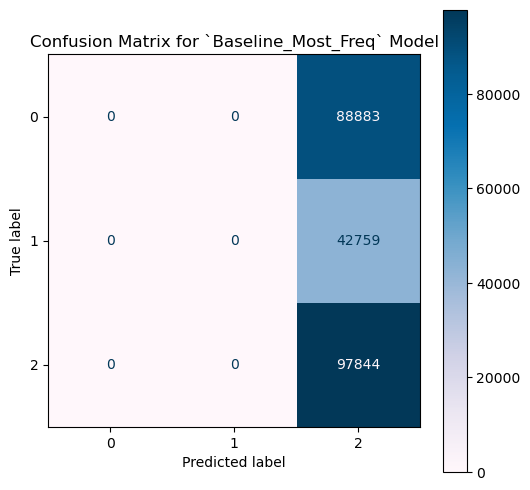

In [19]:
# Instantiate Model
dummy_eval = ModelEval(
    estimator = DummyClassifier(strategy='most_frequent'),
    vectorizer = TfidfVectorizer(),
    name = 'Baseline_Most_Freq')

# Summary stats
dummy_eval.summary()

# Confusion Matrix
dummy_eval.cm()

Alright - 42.6% is the number to beat.

## Multinomial NB


        Training accuracy: 66.68%
        Training loss: 0.77
        Testing accuracy: 61.64%
        Testing loss: 0.82
        

        Negative recall: 65.44%
        Neutral recall: 29.29%  
        Positive recall: 72.33%
        


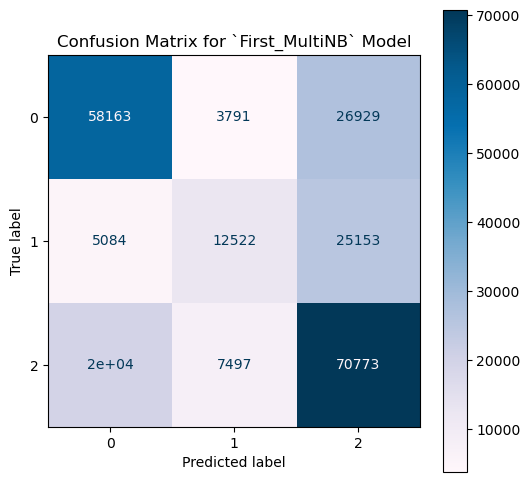

In [14]:
# Instantiate Model
multi_nb_1_eval = ModelEval(
    estimator = MultinomialNB(),
    vectorizer = TfidfVectorizer(),
    name = 'First_MultiNB')

# Summary stats
multi_nb_1_eval.summary()

# Confusion Matrix
multi_nb_1_eval.cm()

Okay - not bad for our first real model! Slightly overfit. Let's see if we can improve this by playing around with the vectorization hyperparameters like `max_df`, `min_df`, `max_features` or `ngram_range`. 

We're not going to keep every instance we try, but rather show a couple successive improvements.


        Training accuracy: 62.71%
        Training loss: 0.82
        Testing accuracy: 62.19%
        Testing loss: 0.82
        

        Negative recall: 64.52%
        Neutral recall: 42.13%  
        Positive recall: 68.84%
        


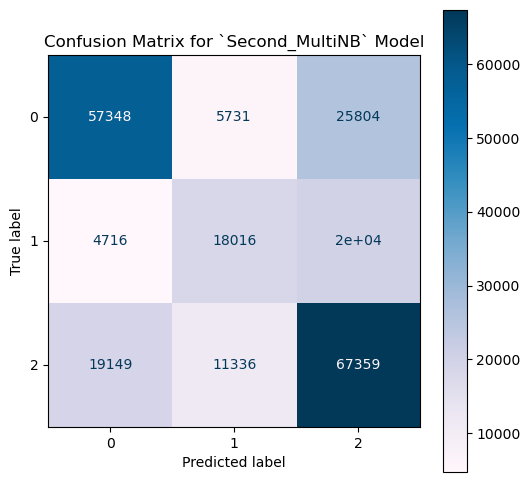

In [22]:
# Instantiate Model
multi_nb_2_eval = ModelEval(
    estimator = MultinomialNB(),
    vectorizer = TfidfVectorizer(max_features=10000),
    name = 'Second_MultiNB')

# Summary stats
multi_nb_2_eval.summary()

# Confusion Matrix
multi_nb_2_eval.cm()

After trying several iterations adjusting `max_df` and `min_df`, we found that those aren't very useful to adjust. They don't seem to make any change up to a certain point, then they tank the model's perfomance. This makes sense given that we are feeding it over 2 million tweets (or documents). `max_features` at 10,000 fixed our overfitting and gave us a tiny boost in performance. Let's look at bigrams and trigrams now.


        Training accuracy: 63.66%
        Training loss: 0.80
        Testing accuracy: 63.05%
        Testing loss: 0.80
        

        Negative recall: 65.20%
        Neutral recall: 49.17%  
        Positive recall: 67.17%
        


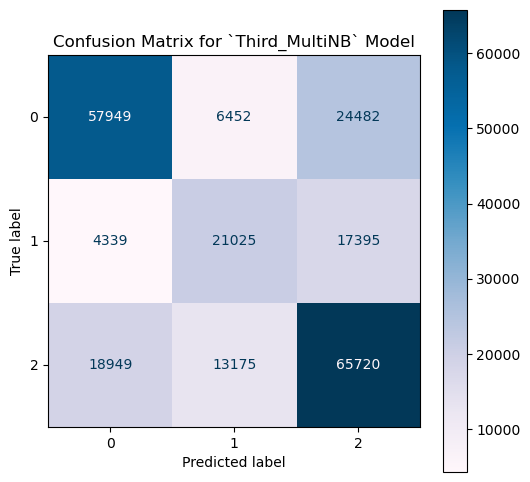

In [12]:
# Instantiate Model
multi_nb_3_eval = ModelEval(
    estimator = MultinomialNB(),
    vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2)),
    name = 'Third_MultiNB')

# Summary stats
multi_nb_3_eval.summary()

# Confusion Matrix
multi_nb_3_eval.cm()

Bigrams helped a bit, trigrams not so much. Let's try another algorithm now.

## Logistic Regression


        Training accuracy: 65.08%
        Training loss: 0.76
        Testing accuracy: 63.99%
        Testing loss: 0.77
        

        Negative recall: 66.60%
        Neutral recall: 48.17%  
        Positive recall: 68.54%
        


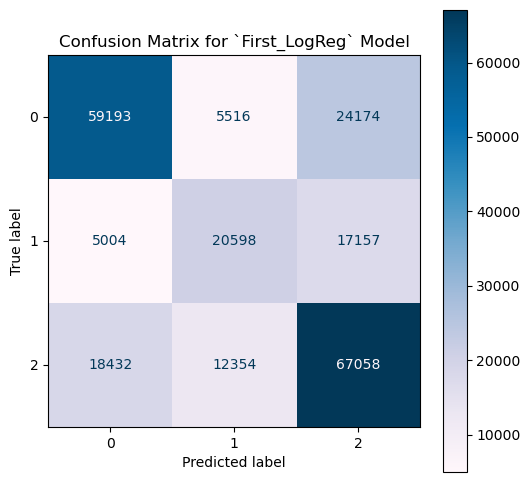

In [13]:
# Instantiate Model
log_reg_1_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=15000),
    name = 'First_LogReg')

# Summary stats
log_reg_1_eval.summary()

# Confusion Matrix
log_reg_1_eval.cm()

Little better than bayes. Let's throw more features and bigrams at it.


        Training accuracy: 65.84%
        Training loss: 0.74
        Testing accuracy: 64.61%
        Testing loss: 0.76
        

        Negative recall: 67.03%
        Neutral recall: 50.65%  
        Positive recall: 68.51%
        


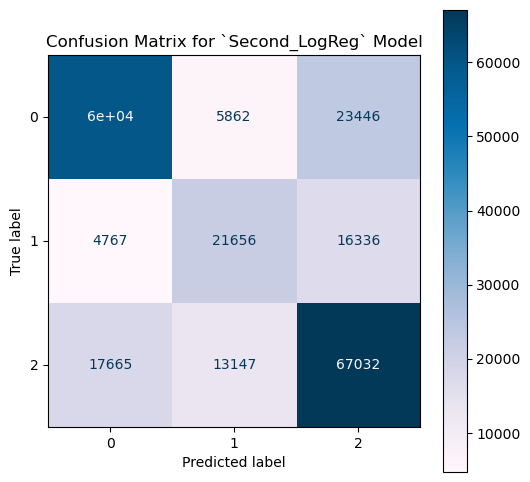

In [12]:
# Instantiate Model
log_reg_2_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2)),
    name = 'Second_LogReg')

# Summary stats
log_reg_2_eval.summary()

# Confusion Matrix
log_reg_2_eval.cm()

Approaching 65%! One more try with even more features.


        Training accuracy: 66.47%
        Training loss: 0.73
        Testing accuracy: 64.78%
        Testing loss: 0.76
        

        Negative recall: 67.23%
        Neutral recall: 51.15%  
        Positive recall: 68.51%
        


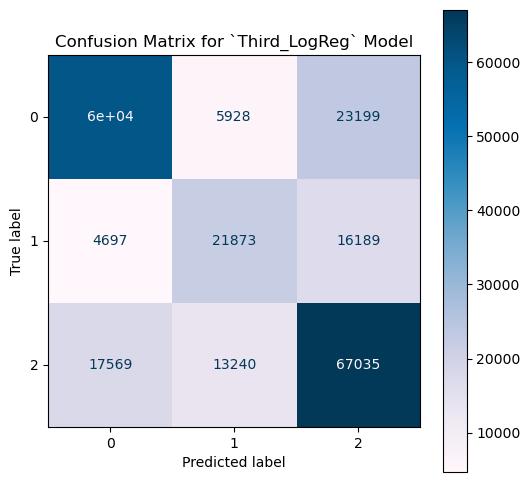

In [16]:
# Instantiate Model
log_reg_3_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2)),
    name = 'Third_LogReg')

# Summary stats
log_reg_3_eval.summary()

# Confusion Matrix
log_reg_3_eval.cm()

## Random Forest

Let's try a random forest. We expect severe overfitting, but we might be surprised! Let's just hope our computer can do it.


        Training accuracy: 67.58%
        Training loss: 0.79
        Testing accuracy: 61.14%
        Testing loss: 0.86
        

        Negative recall: 55.62%
        Neutral recall: 41.27%  
        Positive recall: 74.84%
        


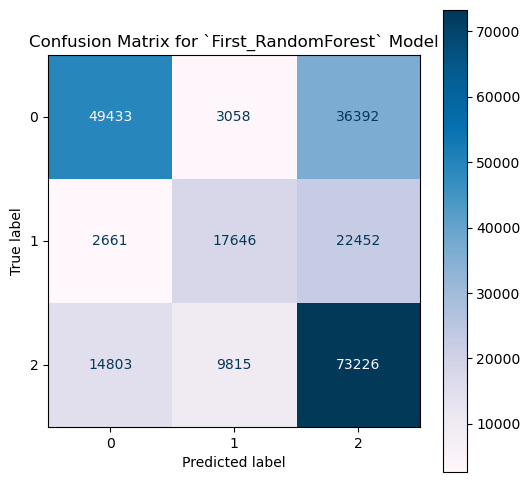

In [12]:
# Instantiate Model
rand_for_1_eval = ModelEval(
    estimator = RandomForestClassifier(random_state=random_state, n_estimators=50, max_depth=100),
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    name = 'First_RandomForest')

# Summary stats
rand_for_1_eval.summary()

# Confusion Matrix
rand_for_1_eval.cm()

This took a looong time to run and didn't make a huge difference. Let's stay focused on Logistic Regression.

## Dropping Neutral Class

Let's see what happens if we drop the neutral class, as it seems to be the hardest for our models to identify.

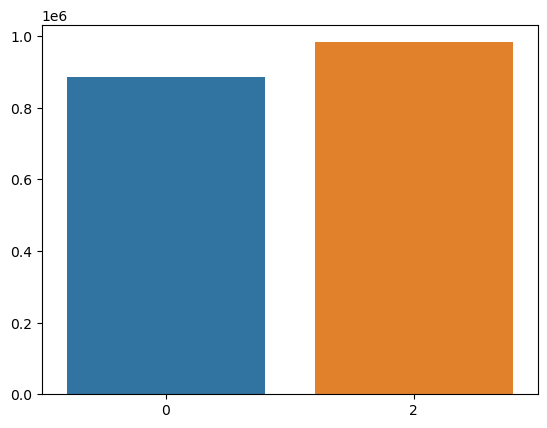

In [11]:
# Bar plot
sns.barplot(x = df.sentiment[df['sentiment']!=1].value_counts().index, 
            y = df.sentiment[df['sentiment']!=1].value_counts().values);

So we would still have about a million tweets for each class. That's enough for us. Let's run our data splits again and define new binary X and Y.

In [12]:
# Split into "train/test" data and "validation" data
X_bin = df.text[df['sentiment']!=1]
y_bin = df.sentiment[df['sentiment']!=1]
X_tt_bin, X_val_bin, y_tt_bin, y_val_bin = train_test_split(X_bin, y_bin, random_state=random_state, test_size=0.1)

# Split into train and test data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_tt_bin, y_tt_bin, random_state=random_state, test_size=(1/9))

Now let's try another LogReg.


        Training accuracy: 76.13%
        Training loss: 0.50
        Testing accuracy: 74.88%
        Testing loss: 0.51
        

            Negative recall: 67.57%
            Positive recall: 81.48%
            


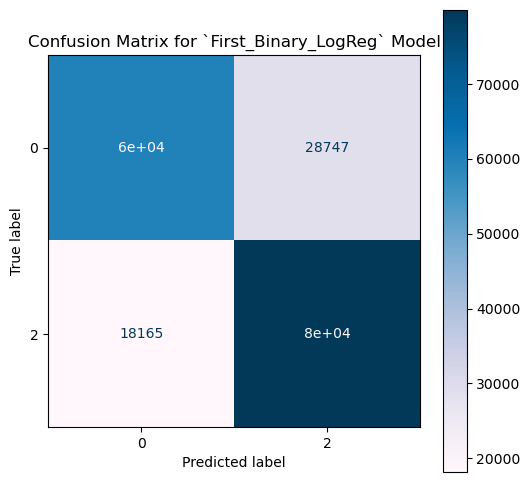

In [13]:
# Instantiate Model
log_reg_binary_1_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2)),
    name = 'First_Binary_LogReg',
    X_train = X_train_bin,
    X_test = X_test_bin,
    y_train = y_train_bin,
    y_test = y_test_bin)

# Summary stats
log_reg_binary_1_eval.summary()

# Confusion Matrix
log_reg_binary_1_eval.cm(binary=True)


        Training accuracy: 77.33%
        Training loss: 0.48
        Testing accuracy: 75.18%
        Testing loss: 0.51
        

            Negative recall: 68.15%
            Positive recall: 81.54%
            


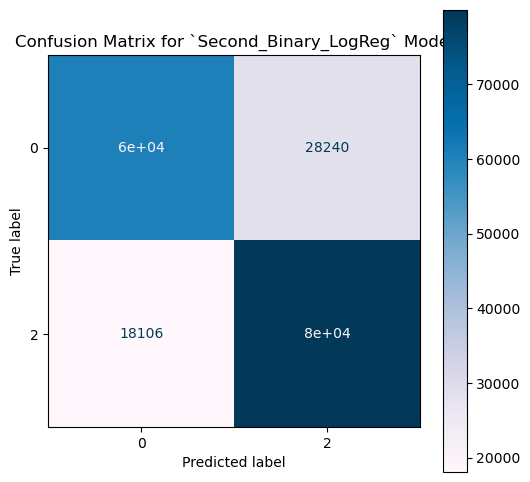

In [19]:
# Instantiate Model
log_reg_binary_2_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=75000, ngram_range=(1,2)),
    name = 'Second_Binary_LogReg',
    X_train = X_train_bin,
    X_test = X_test_bin,
    y_train = y_train_bin,
    y_test = y_test_bin)

# Summary stats
log_reg_binary_2_eval.summary()

# Confusion Matrix
log_reg_binary_2_eval.cm(binary=True)

Okay, 75%! We're going to go with that.

## Train on X_tt and Test on Eval

Let's run one more test of this model using our bigger dataset.


        Training accuracy: 77.23%
        Training loss: 0.48
        Testing accuracy: 75.31%
        Testing loss: 0.51
        

            Negative recall: 68.62%
            Positive recall: 81.33%
            


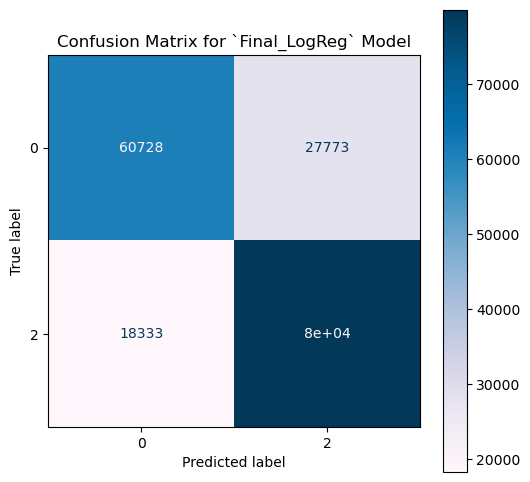

In [20]:
# Instantiate Model
final_log_reg_eval = ModelEval(
    estimator = LogisticRegression(max_iter=1000),
    vectorizer = TfidfVectorizer(max_features=75000, ngram_range=(1,2)),
    name = 'Final_LogReg',
    X_train = X_tt_bin,
    X_test = X_val_bin,
    y_train = y_tt_bin,
    y_test = y_val_bin)

# Summary stats
final_log_reg_eval.summary()

# Confusion Matrix
final_log_reg_eval.cm(binary=True)

## Train on Full Dataset and Save Down

In the interest of time, we will take it. Let's train this model on our full dataset and save it down for deployment.

In [21]:
# Instantiate vectorizer and estimator
vectorizer = TfidfVectorizer(max_features=75000, ngram_range=(1,2))
estimator = LogisticRegression(max_iter=1000)

# Vectorize X_bin
X_bin_vectorized = vectorizer.fit_transform(X_bin)

# Fit LogReg
estimator.fit(X_bin_vectorized, y_bin)

# Accuracy score for sanity
estimator.score(X_bin_vectorized, y_bin)

0.7713309136169832

In [27]:
from joblib import dump
dump(estimator, "final_model.pkl")

['final_model.pkl']